In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
print(parent_dir)
interpolated_dir = os.path.join(parent_dir, "dataset_interpolated_fixed")
# features = ["game_completed", "relative_strength", "score_difference", "type.id", "home_has_possession", "end.down", "end.yardsToEndzone", "end.distance", "field_position_shift", "home_timeouts_left", "away_timeouts_left"]
features = ["game_completed", "relative_strength", "score_difference", "home_has_possession", "end.down", "end.distance", "end.yardsToEndzone",  "home_timeouts_left", "away_timeouts_left"]
# features = ["relative_strength", "score_difference", "home_has_possession"]

/Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/ML


In [3]:
# Reset the modules
modules_to_reload = [
    'process_data',
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

import process_data
training_data = process_data.load_data(interpolated_dir, 
                                       years = [2016, 2017,2018, 2019, 2020, 2021, 2022, 2023], 
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win")

# validation_data = process_data.load_data(interpolated_dir, 
#                                        years = [2023], 
#                                        history_length = 0, 
#                                        features = features, 
#                                        label_feature = "home_win",
#                                        train = True
#                                        )

test_data = process_data.load_data(interpolated_dir, 
                                       years = [2024],
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win",
                                       train = False
                                       )


/Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading data for 2022
  Processing 271 CSV files in parallel with 8 workers...
  Completed processing 2022
Loading data for 2024
skipping  2024
Loading data for 2023
  Processing 272 CSV files in parallel with 8 workers...
  Completed processing 2022
Loading data for 2024
skipping  2024
Loading data for 2023
  Processing 272 CSV files in parallel with 8 workers...
  Completed processing 2023
Loading data for .DS_Store
Loading data for 2017
  Processing 254 CSV files in parallel with 8 workers...
  Completed processing 2023
Loading data for .DS_Store
Loading data for 2017
  Processing 254 CSV files in parallel with 8 workers...
  Completed processing 2017
Loading data for 2019
  Processing 256 CSV files in parallel with 8 workers...
  Completed processing 2017
Loading data for 2019
  Processing 256 CSV files in parallel with 8 workers...
  Completed processing 2019
Loading data for 2021
  Processing 272 CSV files in parallel with 8 workers...
  Completed processing 2019
Loading data for

In [187]:
# Load edge-case datasets (filter by timestep threshold and score_difference)
# Reload module to pick up the new function
modules_to_reload = [
    'process_data',
]
for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]
import process_data
# edge_featues = ["game_completed", "relative_strength", "score_difference", "home_has_possession", "end.down",  "end.distance", "end.yardsToEndzone", "home_timeouts_left", "away_timeouts_left"]
edge_threshold = 0.96  # minimum timestep to include (adjust as needed)
edge_training_data = process_data.load_edge_case_data(
    interpolated_dir,
    years=[2022, 2023],
    history_length=0,
    features=features,
    label_feature='home_win',
    threshold=edge_threshold,
    train=True
)
edge_test_data = process_data.load_edge_case_data(
    interpolated_dir,
    years=[2024],
    history_length=0,
    features=features,
    label_feature='home_win',
    threshold=edge_threshold,
    train=False
)

print('Num train entries:', len(edge_training_data))
print('Num test entries:', len(edge_test_data))

Loading data for 2022
  Processing 271 CSV files in parallel with 8 workers...
  Completed processing 2022
Loading data for 2024
skipping  2024
Loading data for 2023
  Processing 272 CSV files in parallel with 8 workers...
  Completed processing 2023
Loading data for .DS_Store
Loading data for 2017
skipping  2017
Loading data for 2019
skipping  2019
Loading data for 2021
skipping  2021
Loading data for 2020
skipping  2020
Loading data for 2018
skipping  2018
Loading data for 2016
skipping  2016
Loading data for 2022
skipping  2022
Loading data for 2024
  Processing 272 CSV files in parallel with 8 workers...
  Completed processing 2024
Loading data for 2023
skipping  2023
Loading data for .DS_Store
Loading data for 2017
skipping  2017
Loading data for 2019
skipping  2019
Loading data for 2021
skipping  2021
Loading data for 2020
skipping  2020
Loading data for 2018
skipping  2018
Loading data for 2016
skipping  2016
Num train entries: 4686
Num test entries: 2371


In [189]:
# Train a single LogisticRegressionModel on one timestep from the edge-case data
modules_to_reload = [
    'models.logistic_regression',
    'models.Model'
]
for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]
from models.logistic_regression import LogisticRegressionModel
from models.xg_boost import LightGBM
from sklearn.model_selection import train_test_split

# Define numeric/other features here so this cell is self-contained
edge_numeric_features = ["score_difference", "relative_strength", "end.yardsToEndzone", "end.distance"]
edge_other_features = ["home_has_possession", "end.down", "home_timeouts_left", "away_timeouts_left"]
# Define numeric/other features here so this cell is self-contained
edge_numeric_features = [
    "score_difference", 
    "relative_strength", 
    "end.yardsToEndzone", 
    "end.distance",
    "time_remaining_pct",
    "score_diff_x_time",
    "timeout_diff",
    "yards_to_fg_range"
]

edge_other_features = [
    "game_completed",
    "home_has_possession", 
    "end.down", 
    "home_timeouts_left", 
    "away_timeouts_left",
    "home_winning_with_ball",
    "home_winning_no_ball",
    "away_winning_with_ball",
    "away_winning_no_ball",
    "tied",
    "needs_fg_only",
    "needs_td_only",
    "needs_multiple_scores",
    "in_fg_range",     # Binary (0/1) - moved from numeric
    "in_red_zone"      # Binary (0/1) - moved from numeric
]

derived_features = [
    "home_winning_with_ball", "home_winning_no_ball",
    "away_winning_with_ball", "away_winning_no_ball",
    "tied", "time_remaining_pct", "score_diff_x_time",
    "needs_fg_only", "needs_td_only", "needs_multiple_scores",
    "timeout_diff", "yards_to_fg_range", "in_fg_range", "in_red_zone"
]

all_features = features + derived_features
# Choose timestep to train on (by default the largest available)
if not edge_training_data:
    raise ValueError("edge_training_data is empty")

# Prepare training data for selected timestep
X = np.array([entry["rows"].reshape(-1) for entry in edge_training_data])
y = np.array([entry["label"] for entry in edge_training_data])

# Instantiate and train the model
single_model = LogisticRegressionModel(
    numeric_features=edge_numeric_features,
    other_features=edge_other_features,
    all_features=all_features,
    use_calibration=False,
    optimize_hyperparams=False
)

xgboost_model = LightGBM(
    numeric_features=edge_numeric_features,
    other_features=edge_other_features,
    all_features=all_features,
    use_calibration=False,
    optimize_hyperparams=False 
)

single_model.fit(X, y)
print(X[1])
# Keep model in notebook namespace
edge_single_model = single_model
edge_single_model.predict_proba([X[1]])

: Training Loss = 0.4815, Accuracy = 0.7625, Test Loss = 0.5049, Test Accuracy = 0.7397
[9.6666664e-01 8.4880000e-01 4.0000000e+00 0.0000000e+00 2.0000000e+00
 1.2000000e+01 4.7000000e+01 3.0000000e+00 3.0000000e+00 0.0000000e+00
 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.3333335e-02
 1.3333334e-01 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00
 1.0000000e+01 0.0000000e+00 0.0000000e+00]


array([[0.3811275, 0.6188725]])

In [ ]:
# Train a single DirectClassifier (neural network) on one timestep from the edge-case data
modules_to_reload = [
    'models.direct_prediction_network',
    'models.Model'
]
for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

from models.direct_prediction_network import DirectPredictionNetwork, DirectClassifier
import torch
from torch import nn
from sklearn.model_selection import train_test_split

# Prepare training data (flatten rows to 2D)
X = np.array([np.asarray(entry['rows']).reshape(-1) for entry in edge_training_data], dtype=np.float32)
y = np.array([entry['label'] for entry in edge_training_data], dtype=np.float32)
# Train/validation split
if len(X) < 10:
    print(f"Too few samples ({len(X)}) - using all for training")
    X_train, y_train, X_val, y_val = X, y, None, None
else:
    unique, counts = np.unique(y, return_counts=True)
    stratify = y if (len(unique) > 1 and counts.min() >= 2) else None
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42, stratify=stratify)

print(f"Prepared X_train shape: {X_train.shape}, X_val shape: {None if X_val is None else X_val.shape}")

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Build network
input_dim = X.shape[1]
direct_net = DirectPredictionNetwork(input_dim=input_dim, hidden_dims=[64, 32, 16, 8], dropout_rate=0.4, num_layers=4).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(direct_net.parameters(), lr=1e-3, weight_decay=1e-4)

# Instantiate classifier
direct_classifier = DirectClassifier(
    model=direct_net,
    epochs=50,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    features=all_features,  # uses same feature ordering as the dataset
    scheduler=None,
    use_scaler=True,
    optimize_hyperparams=False
)

# Train (classifier handles internal scaling and uses provided val set)
direct_classifier.fit(X_train, y_train, val_X=X_val, val_y=y_val, batch_size=64, verbose=True)

print("Direct classifier training finished.")
print("Train loss:", direct_classifier.final_train_loss)
print("Train accuracy:", direct_classifier.final_train_accuracy)
print("Val loss:", direct_classifier.final_val_loss)
print("Val accuracy:", direct_classifier.final_val_accuracy)

# Keep classifier in notebook namespace
edge_direct_classifier = direct_classifier

Prepared X_train shape: (4217, 23), X_val shape: (469, 23)
Starting training on device: cpu
Early stopping at epoch 36
Best epoch: 26, Train Acc: 0.9251, Train Loss: 0.0585, Val Acc: 0.8678, Val Loss: 0.0961
Restored model from best epoch 26 with val_loss: 0.096134
Direct classifier training finished.
Train loss: 0.05845764312526268
Train accuracy: 0.9250652122361869
Val loss: 0.09613386821001768
Val accuracy: 0.8678038379530917


In [4]:
# other_features = [
#             "type.id",             # Play type (categorical)
#             "home_has_possession", # Binary indicator
#             "end.down",            # Down number (1-4, discrete)
#             "home_timeouts_left",  # Discrete count (0-3)
#             "away_timeouts_left",  # Discrete count (0-3)
#             "game_completed"
#         ]
# numeric_features = [
#     "score_difference",
#     "relative_strength", 
#     "end.yardsToEndzone", 
#     "end.distance", 
#     "field_position_shift"
# ]
other_features = [
            "home_has_possession", # Binary indicator
            # "end.down",            # Down number (1-4, discrete)
            # "home_timeouts_left",  # Discrete count (0-3)
            # "away_timeouts_left",  # Discrete count (0-3)
        ]
numeric_features = [
    "score_difference",
    "relative_strength", 
    # "end.yardsToEndzone", 
    # "end.distance", 
]

In [199]:
class CombinedModel:
    def __init__(self, general_model, specialized_model, original_features, 
                 edge_numeric_features, edge_other_features, scaler=None, 
                 tight_threshold=7, late_game_threshold=0.95):
        """
        Args:
            general_model: Model trained on all game states
            specialized_model: Model trained on late/tight games with derived features
            original_features: List of original feature names
            edge_numeric_features: List of numeric features for specialized model (for normalization)
            edge_other_features: List of binary/categorical features for specialized model
            scaler: Fitted StandardScaler for edge numeric features (optional)
            tight_threshold: Score difference threshold for "tight game" (default 7)
            late_game_threshold: game_completed threshold for "late game" (default 0.95)
        """
        self.general_model = general_model
        self.specialized_model = specialized_model
        self.original_features = original_features
        self.edge_numeric_features = edge_numeric_features
        self.edge_other_features = edge_other_features
        self.scaler = scaler
        self.tight_threshold = tight_threshold
        self.late_game_threshold = late_game_threshold
        
        # Get feature indices from original features
        self.idx_score_diff = original_features.index("score_difference")
        self.idx_game_completed = original_features.index("game_completed")
        self.idx_home_poss = original_features.index("home_has_possession")
        self.idx_yards = original_features.index("end.yardsToEndzone")
        self.idx_home_to = original_features.index("home_timeouts_left")
        self.idx_away_to = original_features.index("away_timeouts_left")
        
    def _is_tight_late_game(self, row):
        """Check if this is a tight late-game situation."""
        score_diff = abs(row[self.idx_score_diff])
        game_completed = row[self.idx_game_completed]
        return (score_diff <= self.tight_threshold and 
                game_completed >= self.late_game_threshold)
    
    def _derive_features(self, row):
        """Derive additional features for specialized model from original features."""
        score_diff = row[self.idx_score_diff]
        game_completed = row[self.idx_game_completed]
        home_poss = row[self.idx_home_poss]
        yards = row[self.idx_yards]
        home_to = row[self.idx_home_to]
        away_to = row[self.idx_away_to]
        
        # Derived features
        home_winning = 1 if score_diff > 0 else 0
        away_winning = 1 if score_diff < 0 else 0
        tied = 1 if score_diff == 0 else 0
        
        home_winning_with_ball = home_winning * home_poss
        home_winning_no_ball = home_winning * (1 - home_poss)
        away_winning_with_ball = away_winning * (1 - home_poss)
        away_winning_no_ball = away_winning * home_poss
        
        time_remaining_pct = 1.0 - game_completed
        score_diff_x_time = score_diff * time_remaining_pct
        
        abs_score_diff = abs(score_diff)
        needs_fg_only = 1 if abs_score_diff <= 3 else 0
        needs_td_only = 1 if 3 < abs_score_diff <= 7 else 0
        needs_multiple_scores = 1 if abs_score_diff > 8 else 0
        
        timeout_diff = home_to - away_to
        
        yards_to_fg_range = max(0, yards - 37)
        in_fg_range = 1 if yards <= 37 else 0
        in_red_zone = 1 if yards <= 20 else 0
        
        derived = {
            "home_winning_with_ball": home_winning_with_ball,
            "home_winning_no_ball": home_winning_no_ball,
            "away_winning_with_ball": away_winning_with_ball,
            "away_winning_no_ball": away_winning_no_ball,
            "tied": tied,
            "time_remaining_pct": time_remaining_pct,
            "score_diff_x_time": score_diff_x_time,
            "needs_fg_only": needs_fg_only,
            "needs_td_only": needs_td_only,
            "needs_multiple_scores": needs_multiple_scores,
            "timeout_diff": timeout_diff,
            "yards_to_fg_range": yards_to_fg_range,
            "in_fg_range": in_fg_range,
            "in_red_zone": in_red_zone
        }
        return derived
    
    def _build_edge_features(self, row):
        """Build feature vector preserving all_edge_features order from training."""
        # Start with original features (already in row)
        feature_dict = {feat: row[self.original_features.index(feat)] 
                    for feat in self.original_features}
        
        # Add derived features
        derived = self._derive_features(row)
        feature_dict.update(derived)
        
        # Build feature vector in EXACT order of all_edge_features (training order)
        edge_features = []
        for feat in feature_dict.keys():
            edge_features.append(feature_dict[feat])
        
        edge_array = np.array(edge_features, dtype=np.float32).reshape(1, -1)
        return edge_array 
    
    def predict_proba(self, X):
        """Predict probabilities, using specialized model for tight late games."""
        result = []
        
        for row in X:
            if self._is_tight_late_game(row):
                # Build edge features and use specialized model
                edge_features = self._build_edge_features(row)
                pred = self.specialized_model.predict_proba(edge_features)[0]
            else:
                # Use general model
                pred = self.general_model.predict_proba(np.array([row]))[0]
            
            result.append(pred)
        
        return np.array(result)
    
    def predict(self, X):
        """Predict class labels."""
        proba = self.predict_proba(X)
        return (proba[:, 1] >= 0.5).astype(int)
    
    def score(self, X, y):
        """Calculate accuracy."""
        predictions = self.predict(X)
        return np.mean(predictions == y)

In [200]:
# Setup model for each timestep
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
# create an array of logistic regression models

modules_to_reload = [
    'models.logistic_regression',
    'models.Model'
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]
from models.Model import Model
from models.logistic_regression import setup_logistic_regression_models

models = setup_logistic_regression_models(training_data, None, numeric_features, other_features, features, optimize_hyperparams=False, use_calibration=False)


Processing timestep: 0.0
Timestep 0.00% : Training Loss = 0.6247, Accuracy = 0.6511, Test Loss = 0.6361, Test Accuracy = 0.6449
Processing timestep: 0.005
Timestep 0.50% : Training Loss = 0.6326, Accuracy = 0.6413, Test Loss = 0.6359, Test Accuracy = 0.6263
Processing timestep: 0.01
Timestep 1.00% : Training Loss = 0.6207, Accuracy = 0.6447, Test Loss = 0.6306, Test Accuracy = 0.6273
Processing timestep: 0.015
Timestep 1.50% : Training Loss = 0.6354, Accuracy = 0.6318, Test Loss = 0.6194, Test Accuracy = 0.6592
Processing timestep: 0.02
Timestep 2.00% : Training Loss = 0.6346, Accuracy = 0.6371, Test Loss = 0.6436, Test Accuracy = 0.6098
Processing timestep: 0.025
Timestep 2.50% : Training Loss = 0.6324, Accuracy = 0.6365, Test Loss = 0.6364, Test Accuracy = 0.6482
Processing timestep: 0.03
Timestep 3.00% : Training Loss = 0.6216, Accuracy = 0.6544, Test Loss = 0.6271, Test Accuracy = 0.6364
Processing timestep: 0.035
Timestep 3.50% : Training Loss = 0.6274, Accuracy = 0.6461, Test Los

In [201]:
def replace_model(models, specialized_model, original_features, 
                 edge_numeric_features, edge_other_features, edge_scaler,
                 threshold=0.95, tight_threshold=7):
    """
    Replace models after a certain threshold with CombinedModel that uses specialized model for edge cases.
    
    Args:
        models: Dict of {timestep: model} 
        specialized_model: The edge-case specialized model
        original_features: List of original feature names
        edge_numeric_features: List of numeric features for specialized model
        edge_other_features: List of binary/categorical features for specialized model
        edge_scaler: Fitted StandardScaler for edge numeric features
        threshold: Timestep threshold above which to use CombinedModel (default 0.95)
        tight_threshold: Score difference threshold for "tight game" (default 7)
    
    Returns:
        new_models: Dict with CombinedModel for timesteps >= threshold
    """
    new_models = {}
    
    for key, general_model in models.items():
        if key >= threshold:
            # Wrap with CombinedModel that can route to specialized model
            new_models[key] = CombinedModel(
                general_model=general_model,
                specialized_model=specialized_model,
                original_features=original_features,
                edge_numeric_features=edge_numeric_features,
                edge_other_features=edge_other_features,
                scaler=edge_scaler,
                tight_threshold=tight_threshold,
                late_game_threshold=threshold  # Use same threshold for consistency
            )
        else:
            # Keep original model for early/mid-game
            new_models[key] = general_model
    
    return new_models
# Usage:
new_models = replace_model(
    models=models,
    specialized_model=edge_single_model,
    original_features=features,
    edge_numeric_features=edge_numeric_features,
    edge_other_features=edge_other_features,
    edge_scaler=None,
    threshold=0.95,
    tight_threshold=7
)

In [202]:
print(models[0.99])
print(new_models[1])

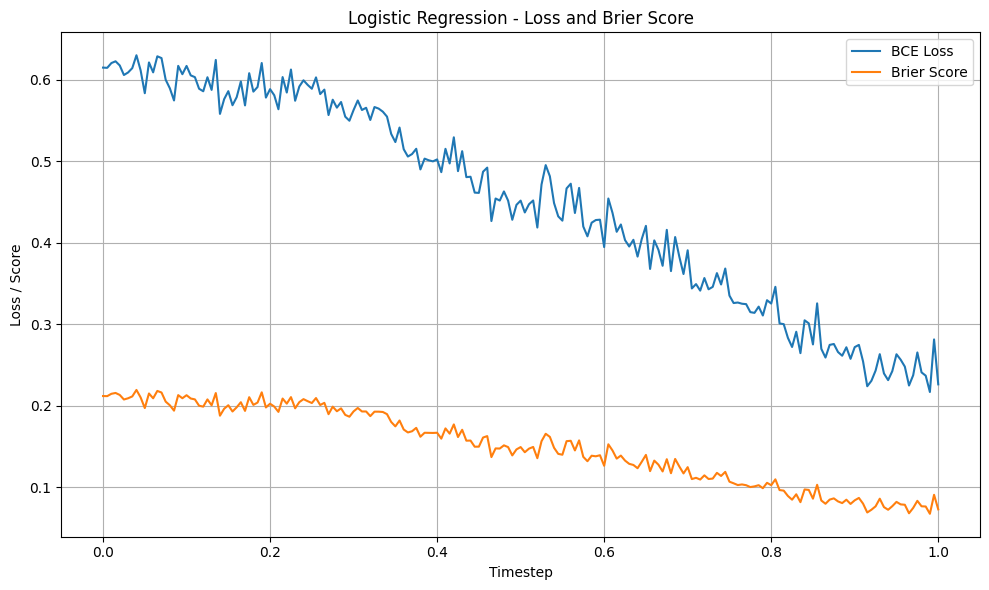

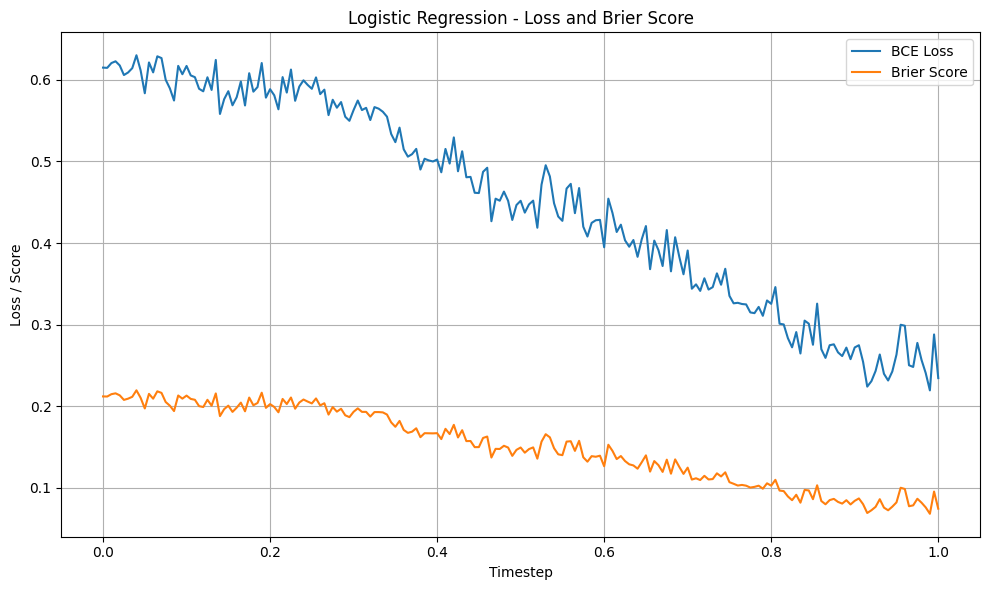

{'timesteps': [0.0,
  0.005,
  0.01,
  0.015,
  0.02,
  0.025,
  0.03,
  0.035,
  0.04,
  0.045,
  0.05,
  0.055,
  0.06,
  0.065,
  0.07,
  0.075,
  0.08,
  0.085,
  0.09,
  0.095,
  0.1,
  0.105,
  0.11,
  0.115,
  0.12,
  0.125,
  0.13,
  0.135,
  0.14,
  0.145,
  0.15,
  0.155,
  0.16,
  0.165,
  0.17,
  0.175,
  0.18,
  0.185,
  0.19,
  0.195,
  0.2,
  0.205,
  0.21,
  0.215,
  0.22,
  0.225,
  0.23,
  0.235,
  0.24,
  0.245,
  0.25,
  0.255,
  0.26,
  0.265,
  0.27,
  0.275,
  0.28,
  0.285,
  0.29,
  0.295,
  0.3,
  0.305,
  0.31,
  0.315,
  0.32,
  0.325,
  0.33,
  0.335,
  0.34,
  0.345,
  0.35,
  0.355,
  0.36,
  0.365,
  0.37,
  0.375,
  0.38,
  0.385,
  0.39,
  0.395,
  0.4,
  0.405,
  0.41,
  0.415,
  0.42,
  0.425,
  0.43,
  0.435,
  0.44,
  0.445,
  0.45,
  0.455,
  0.46,
  0.465,
  0.47,
  0.475,
  0.48,
  0.485,
  0.49,
  0.495,
  0.5,
  0.505,
  0.51,
  0.515,
  0.52,
  0.525,
  0.53,
  0.535,
  0.54,
  0.545,
  0.55,
  0.555,
  0.56,
  0.565,
  0.57,
  0.575,
  0.58,

In [203]:
# # Test accuracy of model for each timestep on test data and plot
# accuracies = []
# timesteps = []
import process_data
modules_to_reload = [
    'process_data',
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

x = process_data.plot_loss(models, test_data, "Logistic Regression")
# process_data.plot_accuracy(models, test_data, "Logistic Regression")
process_data.plot_loss(new_models, test_data, "Logistic Regression")

In [208]:
model = new_models[0.99]
# features = ["relative_strength", "score_difference", "home_has_possession", "end.down", "end.distance", "end.yardsToEndzone",  "home_timeouts_left", "away_timeouts_left"]
data_point = [0.99, 0.5, -8, 1, 1, 1, 1, 1, 1]
model.predict_proba(np.array([data_point]))

array([[0.93568627, 0.06431373]])

In [156]:
# Save the model
import pickle
filename = 'logistic_regression_model.pickle'
pickle.dump(models, open(filename, 'wb'))

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%reload_ext autoreload
from models.utils import SHAP_analysis
# model = models[0.99]
# # Health Check:
# if hasattr(model.model, "coef_"):
#     feature_names = model.all_features if hasattr(model, "all_features") else None
#     coefs = model.model.coef_[0]  # shape (n_features,)
#     if feature_names is not None and len(feature_names) == len(coefs):
#         for name, coef in zip(feature_names, coefs):
#             print(f"{name}: {coef}")

SHAP_analysis(models, training_data, test_data, "logistic_regression", "shap_values/LR", num_threads = 1)
# x = np.array([[0.1, 0.9, 20, 1, 0, 1, 50, 20, 2, 2, 2]])
# model.predict_proba(x)


In [169]:
class HeuristicNFLModel:
    """
    Heuristic-based NFL win probability model using domain knowledge and situational logic.
    """
    
    def __init__(self, features):
        """
        Args:
            features: List of feature names in order
        """
        self.features = features
        self.idx = {feat: i for i, feat in enumerate(features)}
        
    def _sigmoid(self, x, scale=1.0):
        """Smooth sigmoid function."""
        return 1.0 / (1.0 + np.exp(-x / scale))
    
    def _expected_points_from_position(self, yards_to_endzone, down, distance):
        """
        Estimate expected points for the possessing team from current position.
        Based on historical NFL analytics.
        """
        # Field position value (closer to opponent endzone = better)
        if yards_to_endzone <= 10:  # Inside 10
            base_ep = 6.0
        elif yards_to_endzone <= 20:  # Red zone
            base_ep = 4.5
        elif yards_to_endzone <= 40:  # Good field position
            base_ep = 3.0
        elif yards_to_endzone <= 60:  # Midfield area
            base_ep = 2.0
        elif yards_to_endzone <= 80:  # Own territory
            base_ep = 1.0
        else:  # Backed up
            base_ep = 0.3
        
        # Down and distance penalty
        if down == 1:
            down_multiplier = 1.0
        elif down == 2:
            down_multiplier = 0.9 if distance <= 7 else 0.7
        elif down == 3:
            down_multiplier = 0.7 if distance <= 5 else 0.4
        else:  # 4th down
            down_multiplier = 0.2 if distance <= 3 else 0.05
        
        return base_ep * down_multiplier
    
    def _time_value(self, game_completed, score_diff, has_possession):
        """
        Adjust for time remaining and possession.
        Returns multiplier for score difference impact.
        """
        time_remaining = 1.0 - game_completed
        
        # Late game: time becomes critical
        if game_completed > 0.95:  # Final ~3 minutes
            if has_possession and score_diff > 0:
                # Leading with ball late = can run clock
                return 1.5
            elif not has_possession and score_diff < 0:
                # Trailing without ball late = desperate
                return 0.6
        
        return 1.0
    
    def _calculate_win_prob(self, row):
        """Calculate win probability for a single game state."""
        # Extract features
        game_completed = row[self.idx['game_completed']]
        relative_strength = row[self.idx['relative_strength']]
        score_diff = row[self.idx['score_difference']]
        home_has_poss = row[self.idx['home_has_possession']]
        down = row[self.idx['end.down']]
        distance = row[self.idx['end.distance']]
        yards = row[self.idx['end.yardsToEndzone']]
        home_to = row[self.idx['home_timeouts_left']]
        away_to = row[self.idx['away_timeouts_left']]
        
        time_remaining = 1.0 - game_completed
        
        # === Early Game (first 40%) ===
        if game_completed < 0.40:
            # Mostly rely on pre-game strength with small score adjustment
            base_prob = relative_strength
            score_adjustment = self._sigmoid(score_diff, scale=14.0) - 0.5
            return np.clip(base_prob + 0.2 * score_adjustment, 0.01, 0.99)
        
        # === Mid Game (40-85%) ===
        if game_completed < 0.85:
            # Balance pre-game strength and current score
            strength_weight = 0.3
            score_weight = 0.7
            
            base_prob = strength_weight * relative_strength + \
                       score_weight * self._sigmoid(score_diff, scale=10.0)
            
            return np.clip(base_prob, 0.01, 0.99)
        
        # === Late Game (85-95%) ===
        if game_completed < 0.95:
            # Score difference dominates, with possession mattering more
            base_prob = self._sigmoid(score_diff, scale=7.0)
            
            # Possession adjustment based on field position
            if home_has_poss:
                ep = self._expected_points_from_position(yards, down, distance)
                poss_adjustment = ep / 40.0  # Scale to reasonable range
            else:
                ep = self._expected_points_from_position(yards, down, distance)
                poss_adjustment = -ep / 40.0
            
            return np.clip(base_prob + poss_adjustment, 0.01, 0.99)
        
        # === Critical Final Minutes (95%+) ===
        # This is where heuristics really matter
        
        # 1. Check if game is essentially over
        seconds_left = time_remaining * 3600  # Approximate seconds
        
        # Leading team can kneel out clock?
        if score_diff > 0 and home_has_poss:
            # Home leading with ball
            kneels_possible = home_to + away_to + 3  # Timeouts + 3 kneels
            time_to_kneel = kneels_possible * 40
            if seconds_left < time_to_kneel and down < 4:
                return 0.995  # Game essentially over
        
        if score_diff < 0 and not home_has_poss:
            # Away leading with ball
            kneels_possible = home_to + away_to + 3
            time_to_kneel = kneels_possible * 40
            if seconds_left < time_to_kneel and down < 4:
                return 0.005  # Home has essentially lost
        
        # 2. Score difference analysis
        abs_score_diff = abs(score_diff)
        
        # Multiple score game (>8 points)
        if abs_score_diff > 8:
            if score_diff > 0:
                return 0.98 if home_has_poss else 0.95
            else:
                return 0.02 if not home_has_poss else 0.05
        
        # 3. Single-score game analysis (most complex)
        # This is where possession + field position + timeouts matter most
        
        # Calculate expected points for possessing team
        if home_has_poss:
            home_ep = self._expected_points_from_position(yards, down, distance)
            away_ep = 0  # Don't have ball
        else:
            home_ep = 0
            away_ep = self._expected_points_from_position(yards, down, distance)
        
        # Estimate possessions remaining (very rough)
        possessions_left = max(1, time_remaining * 8)  # ~8 possessions per game
        
        # Timeout advantage
        timeout_advantage = (home_to - away_to) * 0.02
        
        # Build probability from components
        if abs_score_diff <= 3:  # Field goal game
            # Need to reach FG range (approximately 35 yards from endzone)
            if home_has_poss:
                can_kick_fg = 1.0 if yards <= 35 else 0.5
                home_scoring_prob = can_kick_fg * 0.7  # ~70% FG success
            else:
                home_scoring_prob = 0.3  # Need to get ball back and score
            
            if score_diff == 0:  # Tied
                base_prob = 0.5 + (home_scoring_prob - 0.35)
            elif score_diff > 0:  # Home leading by FG
                base_prob = 0.65 if home_has_poss else 0.55
            else:  # Home trailing by FG
                base_prob = 0.35 if home_has_poss else 0.45
        
        elif abs_score_diff <= 7:  # Touchdown game
            if score_diff > 0:  # Home leading by TD
                if home_has_poss:
                    # Can run clock, away needs stop + TD drive
                    base_prob = 0.75
                else:
                    # Away has ball, needs TD to tie
                    if yards <= 50:  # Good field position
                        base_prob = 0.60
                    elif yards <= 80:  # Decent position
                        base_prob = 0.70
                    else:  # Backed up
                        base_prob = 0.80
            else:  # Home trailing by TD
                if home_has_poss:
                    # Home needs TD to tie
                    if yards <= 50:
                        base_prob = 0.40
                    elif yards <= 80:
                        base_prob = 0.30
                    else:
                        base_prob = 0.20
                else:
                    # Away has ball, can run clock
                    base_prob = 0.25
        else:
            # Shouldn't hit this, but fallback
            base_prob = self._sigmoid(score_diff, scale=7.0)
        
        # Apply timeout adjustment
        base_prob += timeout_advantage
        
        # Apply pre-game strength (small influence)
        base_prob = 0.9 * base_prob + 0.1 * relative_strength
        
        return np.clip(base_prob, 0.01, 0.99)
    
    def predict_proba(self, X):
        """
        Predict win probabilities.
        
        Args:
            X: Array of shape (n_samples, n_features)
            
        Returns:
            Array of shape (n_samples, 2) with [P(away_win), P(home_win)]
        """
        n_samples = len(X)
        probs = np.zeros((n_samples, 2))
        
        for i, row in enumerate(X):
            home_win_prob = self._calculate_win_prob(row)
            probs[i, 0] = 1 - home_win_prob  # Away win
            probs[i, 1] = home_win_prob      # Home win
        
        return probs
    
    def predict(self, X):
        """Predict class labels (0 = away win, 1 = home win)."""
        probs = self.predict_proba(X)
        return (probs[:, 1] >= 0.5).astype(int)
    
    def score(self, X, y):
        """Calculate accuracy."""
        predictions = self.predict(X)
        return np.mean(predictions == y)

In [212]:
modules_to_reload = [
    "process_data"
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]
import process_data
features = ["game_completed", "relative_strength", "score_difference", "home_has_possession", "end.down", "end.distance", "end.yardsToEndzone",  "home_timeouts_left", "away_timeouts_left"]
class myModel:
    def __init__(self):
        pass
    def predict_proba(self, X):
        return np.array([[0.5, 0.5] for _ in X])
m = HeuristicNFLModel(features)
t = 0.995
process_data.assess_differences(new_models, test_data, t, features, threshold=0.02, alt_model=models[t])

163
-0.07059274701911397
-0.054086596631387894
     game_completed  relative_strength  score_difference  home_has_possession  end.down  end.distance  end.yardsToEndzone  home_timeouts_left  away_timeouts_left  label  predicted  alt_predicted    ESPN      diff
0          0.992500             0.4073              -5.0                  1.0       3.0           1.0                14.0                 1.0                 2.0    1.0   0.142548       0.110316  0.7083 -0.650136
1          0.989167             0.6733               4.0                  0.0       2.0           2.0                13.0                 3.0                 0.0    0.0   0.822343       0.819141  0.2767 -0.599686
2          0.993611             0.4073              -5.0                  1.0       3.0           1.0                86.0                 1.0                 2.0    1.0   0.178030       0.110316  0.7133 -0.593438
3          0.993056             0.2880              -5.0                  1.0       4.0           1.0

In [9]:
from process_data import write_predictions
write_predictions(models, interpolated_dir, [2024], 0, features, replace_nan_val = 0, phat_b = "LR_phat_b")

Loading data for 2024
Processed file:  game_401671629.csv
Processed file:  game_401671601.csv
Processed file:  game_401671826.csv
Processed file:  game_401671601.csv
Processed file:  game_401671826.csv
Processed file:  game_401671832.csv
Processed file:  game_401671749.csv
Processed file:  game_401671832.csv
Processed file:  game_401671749.csv
Processed file:  game_401671775.csv
Processed file:  game_401671761.csv
Processed file:  game_401671775.csv
Processed file:  game_401671761.csv
Processed file:  game_401671760.csv
Processed file:  game_401671774.csv
Processed file:  game_401671760.csv
Processed file:  game_401671774.csv
Processed file:  game_401671748.csv
Processed file:  game_401671833.csv
Processed file:  game_401671748.csv
Processed file:  game_401671833.csv
Processed file:  game_401671827.csv
Processed file:  game_401671600.csv
Processed file:  game_401671827.csv
Processed file:  game_401671600.csv
Processed file:  game_401671628.csv
Processed file:  game_401671616.csv
Proces

In [10]:

import os
import shutil

# Define the ancestor directory and the parent directory
src_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Adjust the number of "../" as needed
dest_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))

# Specify the file or directory to copy from the ancestor directory
source = os.path.join(src_dir, "dataset_interpolated_fixed", "2024")  # Replace with the actual name
destination = os.path.join(dest_dir, "test_7", "LR_ensemble")  # Replace with the desired name

# Perform the copy operation
if os.path.exists(source):
    if os.path.isdir(source):
        shutil.copytree(source, destination)
    else:
        shutil.copy2(source, destination)
    print(f"Copied '{source}' to '{destination}'")
else:
    print(f"Source '{source}' does not exist")

Copied '/Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/ML/dataset_interpolated_fixed/2024' to '/Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/test_7/LR_ensemble'
